In [1]:
from ABDB import database as db
import matplotlib.pyplot as plt
import numpy as np
from retrain_ablooper import *
import torch
import pandas as pd
from rich import print as pprint
from ABlooper import CDR_Predictor

/Users/fabian/miniconda3/envs/auto-db-pipeline/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

model = MaskDecoyGen(decoys=5).to(device = device).float()
model.load_state_dict(torch.load('best_models/best_model-2804-Radam-5-2optim', map_location=torch.device(device)))

batch_size = 1

train = torch.load('train_data/train.pt')
validation = torch.load('train_data/val.pt')
test = torch.load('train_data/test.pt')

val_dataloader = torch.utils.data.DataLoader(validation[:2], 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=True,
                                             pin_memory=True,
                                             )

In [3]:
for val in validation:

    pdb_id = val['ids'][0]
    heavy_c = val['ids'][1]['HC']
    light_c = val['ids'][1]['LC']


    rmsds_refined = []
    rmsds = []

    path = db.fetch(pdb_id).filepath
    input_path = "/".join(path.split("/")[:-1] + ["imgt"] + path.split("/")[-1:])

    output_path1 = pdb_id+heavy_c+light_c+'relaxed.pdb'
    output_path2 = pdb_id+heavy_c+light_c+'.pdb'

    #pred = CDR_Predictor(input_path, chains = (heavy_c, light_c), model=model, refine=True)
    #pred.write_predictions_in_pdb_format(output_path1)
    #rmsds_refined.append(pred.calculate_BB_rmsd_wrt_input())
    
    pred = CDR_Predictor(input_path, chains = (heavy_c, light_c), refine=False)
    pred.write_predictions_in_pdb_format(output_path2)
    rmsds.append(pred.calculate_BB_rmsd_wrt_input())

    break

torch.Size([1, 308, 41])
torch.Size([5, 308, 3])
Are you sure the provided structure is an IMGT numbered antibody?
{'H1': array([[[10.273874 , 10.443808 , 38.090294 ],
        [ 9.667912 ,  9.26624  , 37.307472 ],
        [11.465626 , 10.382423 , 37.30662  ],
        [10.417727 , 10.389438 , 38.136982 ]],

       [[12.768193 ,  9.904219 , 35.499664 ],
        [11.496195 ,  9.650301 , 36.20936  ],
        [12.177629 ,  9.053797 , 34.133324 ],
        [13.969519 ,  9.270803 , 35.88224  ]],

       [[12.705109 ,  9.379227 , 31.59227  ],
        [12.65448  ,  9.373571 , 33.09908  ],
        [13.1080265,  7.843999 , 31.447842 ],
        [13.671908 , 10.229921 , 30.594046 ]],

       [[12.939642 ,  6.0090303, 31.247686 ],
        [12.226106 ,  7.2359514, 31.528534 ],
        [13.718611 ,  5.5761256, 30.123505 ],
        [11.99774  ,  6.2046585, 31.349695 ]],

       [[13.318706 ,  5.410643 , 28.027365 ],
        [13.053449 ,  5.9681883, 29.154913 ],
        [14.299818 ,  5.8359895, 27.14684 

In [3]:
for val in validation:

    pdb_id = val['ids'][0]
    heavy_c = val['ids'][1]['HC']
    light_c = val['ids'][1]['LC']


    rmsds_refined = []
    rmsds = []

    path = db.fetch(pdb_id).filepath
    input_path = "/".join(path.split("/")[:-1] + ["imgt"] + path.split("/")[-1:])

    output_path1 = pdb_id+heavy_c+light_c+'relaxed.pdb'
    output_path2 = pdb_id+heavy_c+light_c+'.pdb'

    #pred = CDR_Predictor(input_path, chains = (heavy_c, light_c), model=model, refine=True)
    #pred.write_predictions_in_pdb_format(output_path1)
    #rmsds_refined.append(pred.calculate_BB_rmsd_wrt_input())
    
    pred = CDR_Predictor(input_path, chains = (heavy_c, light_c), model=model, refine=False)
    pred.write_predictions_in_pdb_format(output_path2)
    rmsds.append(pred.calculate_BB_rmsd_wrt_input())

    break

torch.Size([1, 308, 41])
torch.Size([1, 504])
torch.Size([1, 504, 41])
torch.Size([5, 1, 504, 3])
torch.Size([5, 308, 3])
torch.Size([1, 308, 41])
{'H1': array([[[ 9.926666 ,  6.618889 , 36.086887 ],
        [10.589334 ,  5.5763335, 35.803    ],
        [10.805445 ,  7.3328886, 36.760113 ],
        [ 8.533778 ,  6.4528894, 36.662    ]],

       [[10.965333 ,  5.847778 , 35.51378  ],
        [11.606667 ,  5.0456667, 35.135    ],
        [11.832889 ,  6.3107777, 36.101223 ],
        [ 9.557555 ,  5.667778 , 36.001    ]],

       [[12.004    ,  5.076667 , 34.940666 ],
        [12.624    ,  4.515    , 34.467    ],
        [12.860333 ,  5.2886667, 35.442333 ],
        [10.581333 ,  4.8826666, 35.34     ]],

       [[13.042666 ,  4.3055553, 34.367554 ],
        [13.641333 ,  3.9843335, 33.799    ],
        [13.887777 ,  4.266556 , 34.783443 ],
        [11.605111 ,  4.0975556, 34.679    ]],

       [[14.081332 ,  3.5344443, 33.794445 ],
        [14.658667 ,  3.4536667, 33.131    ],
        [1

In [14]:
pred.output[0,:,0].shape

torch.Size([308])

torch.Size([77])


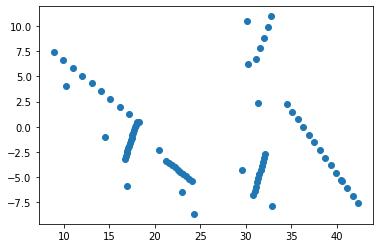

In [22]:
a = rearrange(pred.output, "b (i a) d -> b i a d", a=4)
print(a[0,:,0,0].shape)
plt.scatter(a[0,:,0,0], a[0,:,0,1])

In [9]:
predictions, geomouts, node_features, ids = predict_on_val_set(val_dataloader, model)

Predict validation set ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

In [24]:
with torch.no_grad():
    model.eval()
    for data in val_dataloader:
        coordinates, geomout, node_feature, mask, id = data['geomins'].float().to(device), data['geomouts'].float().to(device), data['encodings'].float().to(device), data['mask'].float().to(device), data['ids']
        pred = model(node_feature, coordinates, mask)
        break
node_feature.shape, coordinates.shape, mask.shape, pred.shape

(torch.Size([1, 504, 41]),
 torch.Size([1, 504, 3]),
 torch.Size([1, 504]),
 torch.Size([5, 1, 504, 3]))

In [9]:
rmsd(pred, geomout)

tensor(0.9859)

Own code for relaxing sturcutres

In [2]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

model = MaskDecoyGen(decoys=5).to(device = device).float()
model.load_state_dict(torch.load('best_models/best_model-2804-Radam-5-2optim', map_location=torch.device(device)))

batch_size = 1

train = torch.load('train_data/train.pt')
validation = torch.load('train_data/val.pt')
test = torch.load('train_data/test.pt')

val_dataloader = torch.utils.data.DataLoader(validation[:1], 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=False,
                                             pin_memory=True,
                                             )

In [20]:
cdr_rmsds, decoy_diversities, pdb_ids = produce_full_structures_of_val_set(val_dataloader, model, outdir='test', relax=False)

predict val set ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

In [21]:
cdr_rmsds, pdb_ids, decoy_diversities

([[0.8096792697906494,
   0.9614585638046265,
   2.295598268508911,
   0.4781680107116699,
   0.3824631869792938,
   0.3483665883541107]],
 ['5hdq'],
 [[0.5077896595001221,
   0.6384487152099609,
   1.2934497833251952,
   0.861171817779541,
   0.41396665573120117,
   0.5191153526306153]])

In [52]:
with torch.no_grad():
    model.eval()
    
    for data in track(val_dataloader, description='predict val set'):

        coordinates, geomout, node_feature, mask, id = data['geomins'].float().to(device), data['geomouts'].float().to(device), data['encodings'].float().to(device), data['mask'].float().to(device), data['ids']
        pred = model(node_feature, coordinates, mask)
        pred = pred.squeeze() # remove batch dimension




        pdb_id = id[0][0]
        heavy_c = id[1]['HC'][0]
        light_c = id[1]['LC'][0]
        chains = [heavy_c, light_c]
        path = db.fetch(pdb_id).filepath
        pdb_file = "/".join(path.split("/")[:-1] + ["imgt"] + path.split("/")[-1:])

        CDR_with_anchor_slices = {
            "H1": (chains[0], (25, 40)),
            "H2": (chains[0], (54, 67)),
            "H3": (chains[0], (103, 119)),
            "L1": (chains[1], (25, 40)),
            "L2": (chains[1], (54, 67)),
            "L3": (chains[1], (103, 119))}
        __atoms = ["CA", "N", "C", "CB"]

        with open(pdb_file) as file:
            pdb_text = [line for line in file.readlines()]

        # For all three of these I extract the loop plus two anchors at either side as these are needed for the model.
        CDR_text = {CDR: [x for x in pdb_text if filt(x, *CDR_with_anchor_slices[CDR])] for CDR in
                         CDR_with_anchor_slices}
        CDR_sequences = {
            CDR: "".join([long2short[x.split()[3][-3:]] for x in CDR_text[CDR] if x.split()[2] == "CA"]) for CDR in
            CDR_with_anchor_slices}

        # Here I don't extract the anchors as this is only needed for writing predictions to pdb file.
        CDR_numberings = {CDR: [x.split()[5] for x in CDR_text[CDR] if x.split()[2] == "CA"][2:-2] for CDR in
                               CDR_text}
        CDR_start_atom_id = {CDR: int([x.split()[1] for x in CDR_text[CDR] if x.split()[2] == "N"][2]) for CDR
                                  in CDR_text}

        predicted_CDRs = {}
        all_decoys = {}
        decoy_diversity = {}

        for i, CDR in enumerate(CDR_with_anchor_slices):
            output_CDR = pred[:, node_feature[0, :, 30 + i] == 1.0]
            all_decoys[CDR] = rearrange(output_CDR, "b (i a) d -> b i a d", a=4).cpu().numpy()
            predicted_CDRs[CDR] = rearrange(output_CDR.mean(0), "(i a) d -> i a d", a=4).cpu().numpy()

        to_be_rewritten = ["H1", "H2", "H3", "L1", "L2", "L3"]

        text_prediction_per_CDR = convert_predictions_into_text_for_each_CDR(CDR_start_atom_id, predicted_CDRs, CDR_sequences, CDR_numberings, CDR_with_anchor_slices)
        old_text = pdb_text

        for CDR in to_be_rewritten:
            new = True
            new_text = []
            chain, CDR_slice = CDR_with_anchor_slices[CDR]
            CDR_slice = (CDR_slice[0] + 2, CDR_slice[1] - 2)

            for line in old_text:
                if not filt(line, chain, CDR_slice):
                    new_text.append(line)
                elif new:
                    new_text += text_prediction_per_CDR[CDR]
                    new = False
                else:
                    continue
            old_text = new_text
    
        header = [
            "REMARK    CDR LOOPS REMODELLED USING ABLOOPER                                   \n"]

        new_text = "".join(header + old_text)

        with open('pdbs/test/'+pdb_id+'-'+heavy_c+light_c+'.pdb', "w+") as file:
            file.write(new_text)

        with open('pdbs/test/'+pdb_id+'-'+heavy_c+light_c+'-true.pdb', "w+") as file:
            file.write("".join(pdb_text))

        

predict val set ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  17% 0:14:44

KeyboardInterrupt: 

In [29]:
for data in val_dataloader:

    coordinates, geomout, node_feature, mask, id = data['geomins'].float().to(device), data['geomouts'].float().to(device), data['encodings'].float().to(device), data['mask'].float().to(device), data['ids']
id 

[('5hdq',), {'HC': ['H'], 'LC': ['L']}]

In [37]:
pdb_id = id[0][0]
heavy_c = id[1]['HC'][0]
light_c = id[1]['LC'][0]

In [38]:
light_c

'L'